# Description 

This script allows to generate a timeseries of the mean value of a variable for a lake_id for lakes_cci version 2.1.0


INPUT:
    <ul>
    <li>The identifier of the lake. The id of the lake is indicated 
      in the csv file containing lake metadata. This file is available 
      at the project website:
      https://admin.climate.esa.int/documents/2607/lakescci_v2.1.0_metadata.csv </li>
    <li>Name of the variable in the netCDF files</li>
    <liLand mask: the netCDF file containing the mask of the lakes in CCI datase (no changes in the landmask between v2.0.1 and v2.1) is available at: https://dap.ceda.ac.uk/neodc/esacci/lakes/data/lake_products/L3S/v2.0.1/ESA_CCI_static_lake_mask_v2.0.1.nc</li>
    <li>First/last dates</li>
    <li>Version of the dataset to be download (default value 2.1.0)</li>
    </ul>

 Reference: Carrea, L.; Crétaux, J.-F.; Liu, X.; Wu, Y.; Bergé-Nguyen,
 M.; Calmettes, B.; Duguay, C.; Jiang, D.; Merchant, C.J.; Mueller, D.;
 Selmes, N.; Simis, S.; Spyrakos, E.; Stelzer, K.; Warren, M.; Yesou,
 H.; Zhang, D. (2022): ESA Lakes Climate Change Initiative (Lakes_cci):
 Lake products, Version 2.1.0. NERC EDS Centre for Environmental Data
 Analysis, date of citation.
 
 https://dx.doi.org/10.5285/7fc9df8070d34cacab8092e45ef276f1
 
    
 WARNING: This script is a beta version. All controls on the input parameters
 are not (yet) available. If you find a bug, have a question or a
 suggestion, don't hesitate to contact us, it will be much appreciated :
 cci_lakes.contact@groupcls.com

 to be executed with python version >= 3.9

# key variables

Lakes_cci dataset is a merged product containing multiple variables from different thematic ECVs. The key variables are as follow:

<b>Lake Water Level (LWL):</b>
<ul><li>water_surface_height_above_reference_datum</li></ul>

<b>Lake Water Extent (LWE):</b>
<ul><li>lake_surface_water_extent</li></ul>

<b>Lake Ice Cover (LIC):</b>
<ul><li>lake_ice_cover_class</li></ul>


<b>Lake Surface Water Temperature (LSWT):</b>
<ul><li>lake_surface_water_temperature</li></ul>


<b>Lake Water Leaving Reflectance (LWLR):</b>
<ul><li>chla_mean</li>
<li>turbidity_mean</li>
<li>Rwxxx with xxx: 400, 412, 443, 469, 490, 510, 531, 547, 560, 620, 645, 665, 674, 681, 709, 754, 779, 859, 885, 900, 1020</li></ul>


In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib widget
%matplotlib inline


Step 1: Define input parameters.

In this exemple, we are interested in the Lakes Water Level (LWL) over Lake Turkana,  a saline lake in the Kenyan Rift Valley, in northern Kenya, with its far northern end crossing into Ethiopia

The lake identifier (22) was obtained from the csv file (https://climate.esa.int/documents/2607/lakescci_v2.1.0_metadata.csv) available in the project website: (https://climate.esa.int/fr/projects/lakes/)

In our case, we are interesteb by data in July 2021


In [21]:
###########################################################################################
# input parameters
###########################################################################################   

# lakes mask file 
maskfile = 'ESA_CCI_static_lake_mask_v2.1.nc'

# Id for lake Turkana: 22
lake_id = 22

# variable name
varname = 'water_surface_height_above_reference_datum'

# defining the period of time in string format: YYYY-MM-DD
# dates values must be between 1992-09-26 and 2020-12-31

mindate = '2021-01-01'
maxdate = '2021-12-31'

In [22]:
# test if dates are in the temporal coverage

mindate = datetime.datetime.strptime(mindate, '%Y-%m-%d')
maxdate = datetime.datetime.strptime(maxdate, '%Y-%m-%d')
mindate = max([mindate, datetime.datetime(1992,9,26)])
maxdate = min([maxdate, datetime.datetime(2022,12,31)])


# Step 2: Mask creation

In this step, latitude and longitude values inside the lake are obtained from the lake mask file. The boundary values will then be used to read the data in the region covering the lake.

In [16]:

###################################################################
# create mask based on lake_id
###################################################################

mask_xr = xr.open_dataset(maskfile)
mask = mask_xr['CCI_lakeid'].values
mask_ind  = np.where(mask == lake_id)
minx = np.min(mask_ind[1][:]) - 1
maxx = np.max(mask_ind[1][:]) + 1
miny = np.min(mask_ind[0][:]) - 1
maxy = np.max(mask_ind[0][:]) + 1

mask_lake = mask[miny:maxy+1, minx:maxx+1]
mask_lake[mask_lake!=lake_id] = 0
mask_lake[mask_lake == lake_id] = 1

lat = mask_xr['lat'][miny:maxy+1].values
lon = mask_xr['lon'][minx:maxx+1].values


A good validation test is to check that the lake ID is correct by visualising the lake mask.

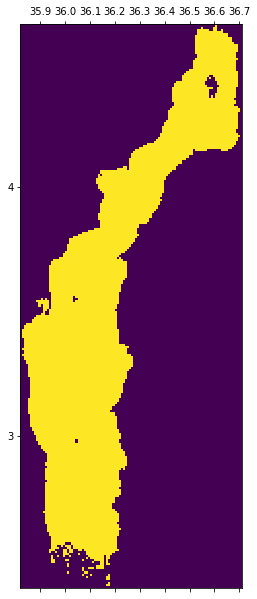

In [17]:
# plot lake mask 
plt.matshow(mask_lake, extent=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)])
plt.show()

# Step 3: Data reading

In this step, the data for the defined lake and variable is read from each daily file and the mean value estimated 


In [ ]:
date_vec = []
data_vec = []
version = 2.1

for data_date in np.arange(mindate.toordinal(), maxdate.toordinal()+1):
    current_date = datetime.datetime.fromordinal(data_date)
    date_str = current_date.strftime("%Y%m%d")
    
    #print (f'Downloading data from lake_id {lake_id} -  ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.0.nc')
   
    path = f'https://data.cci.ceda.ac.uk/thredds/dodsC/esacci/lakes/data/lake_products/L3S/v{version}/merged_product/'
    path += f'{current_date.year}/{current_date.month:02}/'
    path += f'ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.0.nc?{varname}'
  
    dataset = xr.open_dataset(path, engine="pydap" )
    dataset = dataset.isel(lat=slice(miny, maxy+1), lon=slice(minx, maxx+1))
    units  = dataset[varname].units
    filval = dataset[varname].encoding['_FillValue']
    data = dataset[varname][0,:,:].values
    
    data[mask_lake == 0] = np.nan
    
    # only keep dates with no NaN values
    if np.isnan(data).all() :
        continue

    date_vec.append(date_str)
    data_vec.append(np.nanmean(data))
    

Generate a dataframe with date and data vectors

In [24]:
df = pd.DataFrame({'date': date_vec, f'{varname}': data_vec})
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

# Step 4: Visualisation

Visualisation of the timeseries during the selected period

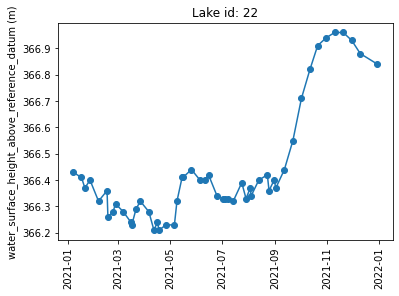

In [25]:
if units == '1' :
    units = 'no units'
plt.plot(df['date'], df[varname], marker='o')
plt.title(f'Lake id: {lake_id}')
plt.ylabel(f'{varname} ({units})')
plt.xticks(rotation=90)
plt.show()

Time series of the mean data can be saved to a csv file to later use or analysis. 

In [12]:
df[varname] = np.round(df[varname], 3)
df.to_csv('Turkana_lwe.csv', index = False)